# Small World Graphs

Code examples from [Think Complexity, 2nd edition](http://greenteapress.com/wp/complexity2), Chapter 3

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
from __future__ import print_function, division

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import networkx as nx
import numpy as np

import thinkplot

# colors from our friends at http://colorbrewer2.org
COLORS = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462',
          '#b3de69','#fccde5','#d9d9d9','#bc80bd','#ccebc5','#ffed6f']

In [2]:
from thinkstats2 import RandomSeed
RandomSeed(17)

## Regular ring lattice

To make a ring lattice, I'll start with a generator function that yields edges between each node and the next `halfk` neighbors.

In [3]:
def adjacent_edges(nodes, halfk):
    """Yields edges between each node and `halfk` neighbors.
    
    halfk: number of edges from each node
    """
    n = len(nodes)
    for i, u in enumerate(nodes):
        for j in range(i+1, i+halfk+1):
            v = nodes[j % n]
            yield u, v

We can test it with 3 nodes and `halfk=1`

In [4]:
nodes = range(3)
for edge in adjacent_edges(nodes, 1):
    print(edge)

(0, 1)
(1, 2)
(2, 0)


Now we use `adjacent_edges` to write `make_ring_lattice`

In [5]:
def make_ring_lattice(n, k):
    """Makes a ring lattice with `n` nodes and degree `k`.
    
    Note: this only works correctly if k is even.
    
    n: number of nodes
    k: degree of each node
    """
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(adjacent_edges(nodes, k//2))
    return G

And we can test it out with `n=10` and `k=4`

In [6]:
lattice = make_ring_lattice(10, 4)

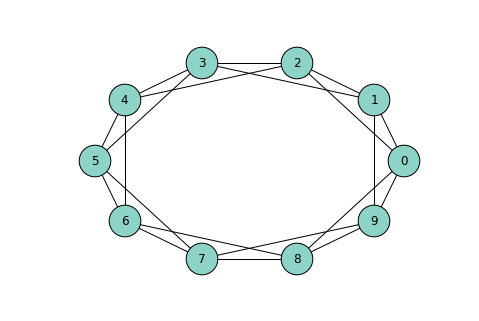

In [7]:
nx.draw_circular(lattice, 
                 node_color=COLORS[0], 
                 node_size=1000, 
                 with_labels=True)
plt.savefig('chap03-1.pdf')

**Exercise:** To see how this function fails when `k` is odd, run it again with `k=3` or `k=5`.

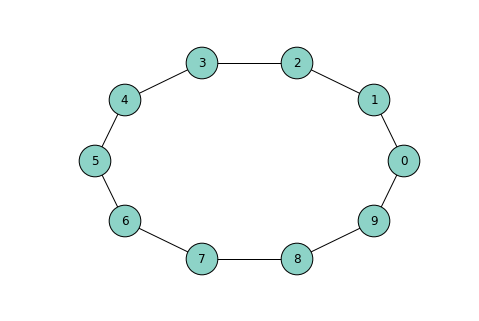

In [8]:
another_lattice = make_ring_lattice(10, 3)
# If it succeeded, each node would have 5 edges coming out of it.  It still has 4 edges.
nx.draw_circular(another_lattice, 
                 node_color=COLORS[0], 
                 node_size=1000, 
                 with_labels=True)

## WS graph

To make a WS, you start with a ring lattice and then rewire.

In [9]:
def make_ws_graph(n, k, p):
    """Makes a Watts-Strogatz graph.
    
    n: number of nodes
    k: degree of each node
    p: probability of rewiring an edge
    """
    ws = make_ring_lattice(n, k)
    rewire(ws, p)
    return ws

Here's the function that does the rewiring

In [10]:
from numpy.random import choice

def rewire(G, p):
    """Rewires each edge with probability `p`.
    
    G: Graph
    p: float
    """
    nodes = set(G.nodes())
    for edge in G.edges():
        if flip(p):
            u, v = edge
            choices = nodes - {u} - set(G[u])
            new_v = choice(tuple(choices))
            G.remove_edge(u, v)
            G.add_edge(u, new_v)
            
def flip(p):
    """Returns True with probability `p`."""
    return np.random.random() < p

Here's an example with `p=0.2`

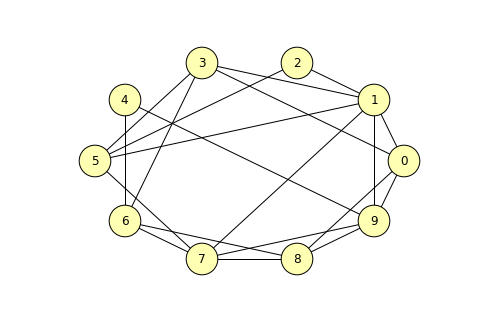

In [11]:
ws = make_ws_graph(10, 4, 0.2)
nx.draw_circular(ws, 
                 node_color=COLORS[1], 
                 node_size=1000, 
                 with_labels=True)

Just checking that we have the same number of edges we started with:

In [12]:
len(lattice.edges()), len(ws.edges())

(20, 20)

Now I'll generate a plot that shows WS graphs for a few values of `p`

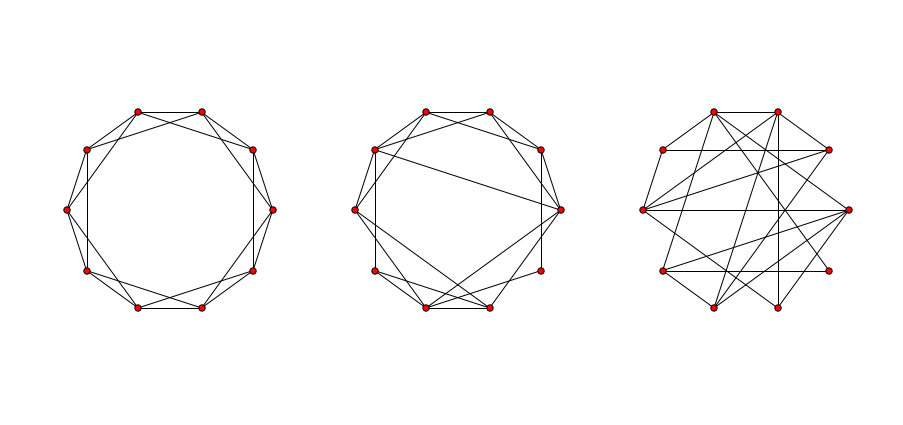

In [13]:
n = 10
k = 4
ns = 40

thinkplot.preplot(cols=3)
ws = make_ws_graph(n, k, 0)
nx.draw_circular(ws, node_size=ns)
thinkplot.config(axis='equal')

thinkplot.subplot(2)
ws = make_ws_graph(n, k, 0.2)
nx.draw_circular(ws, node_size=ns)
thinkplot.config(axis='equal')

thinkplot.subplot(3)
ws = make_ws_graph(n, k, 1.0)
nx.draw_circular(ws, node_size=ns)
thinkplot.config(axis='equal')

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1)
plt.savefig('chap03-2.pdf')

**Exercise:** What is the order of growth of `rewire`?

In [14]:
# Solution goes here

# Rewire has growth O(n*m), where n is total nodes, m is total edges.

# def rewire(G, p):
#     """Rewires each edge with probability `p`.
    
#     G: Graph
#     p: float
#     """
#     nodes = set(G.nodes())  # O(n)
#     for edge in G.edges():  # O(m)
#         if flip(p):         # O(1)
#             u, v = edge
#             choices = nodes - {u} - set(G[u])  # O(n-1)
#             new_v = choice(tuple(choices)) # Random Pointer is O(1)
#             G.remove_edge(u, v)   # O(1)
#             G.add_edge(u, new_v)  # O(1)


## Clustering

The following function computes the local clustering coefficient for a given node, `u`:

In [15]:
def node_clustering(G, u):
    """Computes local clustering coefficient for `u`.
    
    G: Graph
    u: node
    
    returns: float
    
    In O(n^2)
    """
    neighbors = G[u]
    k = len(neighbors)
    if k < 2:
        return 0
        
    total = k * (k-1) / 2
    exist = 0    
    for v, w in all_pairs(neighbors):  # O(n^2)
        if G.has_edge(v, w): # O(1)
            exist +=1
    return exist / total

def all_pairs(nodes):
    """Generates all pairs of nodes.
    In O(n^2)
    """
    for i, u in enumerate(nodes): # O(n)
        for j, v in enumerate(nodes): # O(n)
            if i < j: 
                yield u, v

The network average clustering coefficient is just the mean of the local CCs.

In [16]:
def clustering_coefficient(G):
    """Average of the local clustering coefficients.
    
    G: Graph
    
    returns: float
    """
    cc = np.mean([node_clustering(G, node) for node in G])
    return cc

In a ring lattice with `k=4`, the clustering coefficient for each node should be 0.5

In [17]:
lattice = make_ring_lattice(10, 4)
node_clustering(lattice, 1)

0.5

And the network average should be 0.5

In [18]:
clustering_coefficient(lattice)

0.5

Correct.

**Exercise:** Write a version of `node_clustering` that replaces the `for` loop with a list comprehension.

In [19]:
# Solution goes here

def node_clustering(G, u):
    """Computes local clustering coefficient for `u`.
    
    G: Graph
    u: node
    
    returns: float
    """
    neighbors = G[u]
    k = len(neighbors)
    if k < 2:
        return 0
        
    total = k * (k-1) / 2
    exist = sum([1 for v, w in all_pairs(neighbors) if G.has_edge(v, w)])
    return exist / total

**Exercise:** What is the order of growth of `clustering_coefficient` in terms of `n`, `m`, and `k`?

In [20]:
# Solution goes here

# clustering_coefficient is in O(n^3)

# def clustering_coefficient(G):
#     """Average of the local clustering coefficients.
    
#     G: Graph
    
#     returns: float
#     """
#     foo = [node_clustering(G, node) for node in G] # O(n^2 * n)  
#     cc = np.mean(foo) # O(n)
#     return cc

## Path length

The following function computes path lengths between all pairs of nodes

In [21]:
def path_lengths(G):
    length_map = nx.shortest_path_length(G)
    lengths = [length_map[u][v] for u, v in all_pairs(G)]
    return lengths

The characteristic path length is the mean path length for all pairs.

In [22]:
def characteristic_path_length(G, do_plot=False):
    foo = path_lengths(G)
    if do_plot:
        plt.hist(foo)
    return np.mean(foo)

On a complete graph, the average path length should be 1

1.0

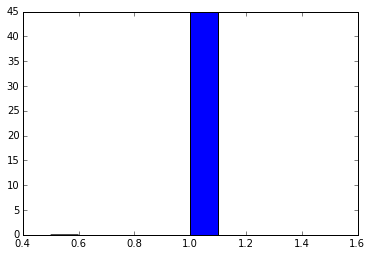

In [23]:
complete = nx.complete_graph(10)
characteristic_path_length(complete, True)

On a ring lattice with `n=1000` and `k=10`, the mean is about 50

50.450450450450454

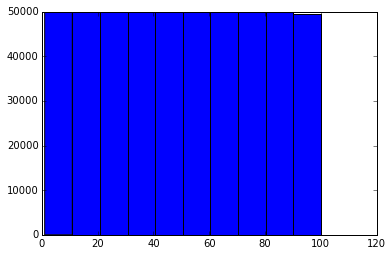

In [24]:
lattice = make_ring_lattice(1000, 10)
characteristic_path_length(lattice, True)

**Exercise:**  What is the mean path length in a ring lattice with `n=10` and `k=4`?

1.6666666666666667

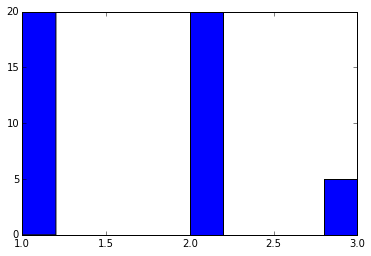

In [25]:
# Solution goes here 
characteristic_path_length(make_ring_lattice(10, 4), True)

## The experiment

This function generates a WS graph with the given parameters and returns a pair of (mean path length, clustering coefficient):

In [26]:
def run_one_graph(n, k, p):
    """Makes a WS graph and computes its stats.
    
    n: number of nodes
    k: degree of each node
    p: probability of rewiring
    
    returns: tuple of (mean path length, clustering coefficient)
    """
    ws = make_ws_graph(n, k, p)    
    mpl = characteristic_path_length(ws)
    cc = clustering_coefficient(ws)
    print(mpl, cc)
    return mpl, cc

With `n=1000` and `k=10`, it takes about a second on my computer:

In [27]:
%time run_one_graph(1000, 10, 0.01)

8.28896696697 0.644773015873
CPU times: user 1.03 s, sys: 73.1 ms, total: 1.1 s
Wall time: 1.03 s


(8.2889669669669672, 0.64477301587301572)

Now we'll run it with a range of values for `p`.

In [28]:
ps = np.logspace(-4, 0, 9)
print(ps)

[  1.00000000e-04   3.16227766e-04   1.00000000e-03   3.16227766e-03
   1.00000000e-02   3.16227766e-02   1.00000000e-01   3.16227766e-01
   1.00000000e+00]


This function runs each value of `p` 20 times and returns a dictionary that maps from each `p` to a list of (mpl, cc) pairs.

In [29]:
def run_experiment(ps, n=1000, k=10, iters=20):
    """Computes stats for WS graphs with a range of `p`.
    
    ps: sequence of `p` to try
    n: number of nodes
    k: degree of each node
    iters: number of times to run for each `p`
    
    returns: sequence of (mpl, cc) pairs
    """
    res = {}
    for p in ps:
        print(p)
        res[p] = []
        for _ in range(iters):
            res[p].append(run_one_graph(n, k, p))
    return res

Here are the raw results

In [30]:
# res = run_experiment(ps)

Now we have to extract them in a form we can plot

In [31]:
# L = []
# C = []
# for p, t in sorted(res.items()):
#     mpls, ccs = zip(*t)
#     mpl = np.mean(mpls)
#     cc = np.mean(ccs)
#     L.append(mpl)
#     C.append(cc)
    
# print(L)
# print(C)

And normalize them so they both start at 1.0

In [32]:
# L = np.array(L) / L[0]
# C = np.array(C) / C[0]

Here's the plot that replicates Watts and Strogatz's Figure 2.

In [33]:
# thinkplot.plot(ps, L, style='o-', linewidth=1)
# thinkplot.plot(ps, C, style='s-', linewidth=1)
# thinkplot.text(0.001, 0.9, 'C(p) / C(0)')
# thinkplot.text(0.0005, 0.25, 'L(p) / L(0)')
# thinkplot.config(xlabel='p', xscale='log',
#                  xlim=[0.00009, 1.1], ylim=[-0.01, 1.01])
# plt.savefig('chap03-3.pdf')

## Breadth-first search

Now let's see how the shortest path algorithm works.  We'll start with BFS, which is the basis for Dijkstra's algorithm.

Here's our old friend, the ring lattice:

In [34]:
lattice = make_ring_lattice(10, 4)

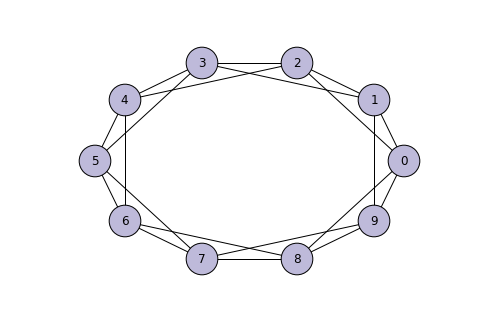

In [35]:
nx.draw_circular(lattice, 
                 node_color=COLORS[2], 
                 node_size=1000, 
                 with_labels=True)

And here's my implementation of BFS using a deque.

In [36]:
from collections import deque

def reachable_nodes_bfs(G, start):
    """Finds reachable nodes by BFS.
    
    G: graph
    start: node to start at
    
    returns: set of reachable nodes
    """
    seen = set()
    queue = deque([start])
    while queue:
        node = queue.popleft()
        if node not in seen:
            seen.add(node)
            queue.extend(G.neighbors(node))
    return seen

It works:

In [37]:
reachable_nodes_bfs(lattice, 0)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

Here's a version that's a little faster, but maybe less readable.

In [38]:
def reachable_nodes_bfs(G, start):
    """Finds reachable nodes by BFS.
    
    G: graph
    start: node to start at
    
    returns: set of reachable nodes
    """
    seen = set()
    queue = deque([start])
    while queue:
        node = queue.popleft()
        if node not in seen:
            seen.add(node)
            neighbors = set(G[node]) 
            neighbors -= seen
            queue.extend(neighbors)
    return seen

It works, too.

In [39]:
reachable_nodes_bfs(lattice, 0)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

## Dijkstra's algorithm

Now we're ready for Dijkstra's algorithm, at least for graphs where all the edges have the same weight/length.

In [40]:
def shortest_path_dijkstra(G, start):
    """Finds shortest paths from `start` to all other nodes.
    
    G: graph
    start: node to start at
    
    returns: make from node to path length
    """
    dist = {start: 0}
    queue = deque([start])
    while queue:
        node = queue.popleft()
        new_dist = dist[node] + 1

        neighbors = set(G[node]) - set(dist)
        for n in neighbors:
            dist[n] = new_dist
        
        queue.extend(neighbors)
    return dist

Again, we'll test it on a ring lattice.

In [41]:
lattice = make_ring_lattice(10, 4)

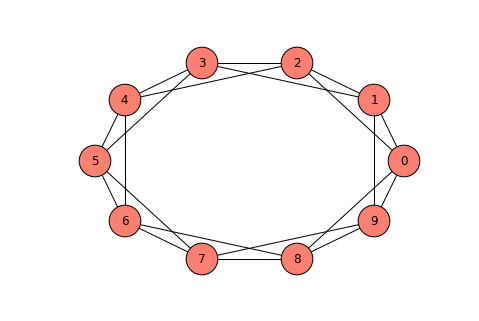

In [42]:
nx.draw_circular(lattice, 
                 node_color=COLORS[3], 
                 node_size=1000, 
                 with_labels=True)

Here's my implementation:

In [43]:
d1 = shortest_path_dijkstra(lattice, 0)
d1

{0: 0, 1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 2, 7: 2, 8: 1, 9: 1}

And here's the result from NetworkX:

In [44]:
d2 = nx.shortest_path_length(lattice, 0)
d2

{0: 0, 1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 2, 7: 2, 8: 1, 9: 1}

They are the same:

In [45]:
d1 == d2

True

**Exercise:** In a ring lattice with `n=1000` and `k=10`, which node is farthest from 0 and how far is it?  Use `shortest_path_dijkstra` to check your answer.

Note: the maximum distance between two nodes is the **diameter** of the graph.

In [46]:
# Solution goes here
lattice = make_ring_lattice(1000, 10)
d3 = shortest_path_dijkstra(lattice, 0)

In [47]:
# http://stackoverflow.com/questions/268272/getting-key-with-maximum-value-in-dictionary
import operator

max(d3.iteritems(), key=operator.itemgetter(1))

(496, 100)

## Exercises

**Exercise:** In a ring lattice, every node has the same number of neighbors.  The number of neighbors is called the **degree** of the node, and a graph where all nodes have the same degree is called a **regular graph**.

All ring lattices are regular, but not all regular graphs are ring lattices.  In particular, if `k` is odd, we can't construct a ring lattice, but we might be able to construct a regular graph.

Write a function called `make_regular_graph` that takes `n` and `k` and returns a regular graph that contains `n` nodes, where every node has `k` neighbors.  If it's not possible to make a regular graph with the given values of `n` and `k`, the function should raise a `ValueError`.

In [49]:
# Solution goes here
# HandShake Lemma: n*k must be even, in order to construct a regular graph.
# Source: https://en.wikipedia.org/wiki/Handshaking_lemma

# Idea:
# If n*k is odd, we raise an Error
# If k is even, we can make a ring lattice
# If k is odd, we can do a ring lattice with k - 1.
#     Then add a final connection directly across the graph to make k

def diagonal_edges(nodes):
    """Yields edges between each node and its diagonal
    or directly opposite or most distant neighbor, based on a 
    circular visualization"""
    n = len(nodes)
    halfn = n // 2
    for i, u in enumerate(nodes):
        v = nodes[(i + halfn) % n]
        yield u, v

In [50]:
def make_diagonal_ring_lattice(n):
    """ Create a ring lattice where the 
    diagonal nodes are connected """
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(diagonal_edges(nodes))
    return G

In [51]:
def make_regular_graph(n, k):
    """
    If n*k is odd, we raise an Error
    If k is even, we can make a ring lattice
    If k is odd, we can do a ring lattice with k - 1.
        Then add a final connection directly across the graph to make k
    """
    if n*k % 2 == 1:
        raise ValueError("Not possible to make a regular graph with given values of n and k")

    G = nx.Graph()
    nodes = range(n)
    nodes_as_dict = {n: {} for n in nodes}
    G.add_nodes_from(nodes)

    # Construct a ring lattice
    G.add_edges_from(adjacent_edges(nodes, k//2))

    if k % 2 == 1:
        # Constructing a ring lattice made k - 1 edges per node
        # Add a final diagonal edge to make degree k
        G.add_edges_from(diagonal_edges(nodes))

    return G

In [52]:
# n*k is odd
make_regular_graph(7, 3)

ValueError: Not possible to make a regular graph with given values of n and k

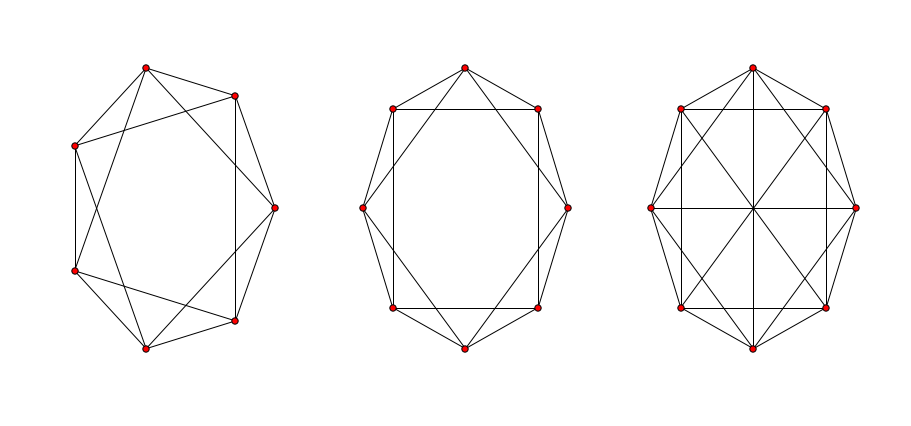

In [53]:
ns = 40
thinkplot.preplot(cols=3)

# n*k is even, k is even
nx.draw_circular(make_regular_graph(7, 4),  
                 node_size=ns)
thinkplot.subplot(2)
nx.draw_circular(make_regular_graph(8, 4), 
                 node_size=ns)

# n*k is even, k is odd
thinkplot.subplot(3)
nx.draw_circular(make_regular_graph(8, 5), 
                 node_size=ns)

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1)

__Exercise__: My implementation of `reachable_nodes_bfs` is efficient in the sense that it is in $O(n + m)$, but it incurs a lot of overhead adding nodes to the queue and removing them. NetworkX provides a simple, fast implementation of BFS, available from [the NetworkX repository on GitHub](https://github.com/networkx/networkx/blob/master/networkx/algorithms/components/connected.py).


Here is a version I modified to return a set of nodes:

In [54]:
def plain_bfs(G, source):
    """A fast BFS node generator"""
    seen = set() # 1
    nextlevel = {source} # 1
    while nextlevel:
        thislevel = nextlevel # 1
        nextlevel = set() # 1
        for v in thislevel: # k^2?
            if v not in seen: # 1
                seen.add(v) # 1
                nextlevel.update(G[v]) # k
    return seen

In [55]:
# def reachable_nodes_bfs(G, start):
#     """Finds reachable nodes by BFS.
    
#     G: graph
#     start: node to start at
    
#     returns: set of reachable nodes
#     """
#     seen = set()
#     queue = deque([start])
#     while queue:
#         node = queue.popleft()
#         if node not in seen:
#             seen.add(node)
#             queue.extend(G.neighbors(node))
#     return seen

Compare this function to `reachable_nodes_bfs` and see which is faster.  Then see if you can modify this function to implement a faster version of `shortest_path_dijkstra`

In [56]:
def get_nk_pairs():
    nodes = [1e1, 1e2, 1e3]
    degrees = [5e-1, 5e0, 5e1]
    for n, k in zip(nodes, degrees):
        yield int(n), int(k)

In [57]:
lattices = [make_ring_lattice(n, k) for n, k in get_nk_pairs()]

for i, lattice in enumerate(lattices):
    print("n: {}, m: {}".format(lattice.number_of_nodes(), lattice.number_of_edges()))
    %time plain_bfs(lattice, 0)
    %time reachable_nodes_bfs(lattice, 0)
    print("\n")

n: 10, m: 0
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 16.9 µs
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 12.2 µs


n: 100, m: 200
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 88 µs
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 215 µs


n: 1000, m: 25000
CPU times: user 1.28 ms, sys: 0 ns, total: 1.28 ms
Wall time: 1.39 ms
CPU times: user 9.45 ms, sys: 0 ns, total: 9.45 ms
Wall time: 9.13 ms




In [91]:
def shortest_path_dijkstra_v2(G, start):
    """Finds shortest paths from `start` to all other nodes.
    
    Faster v2 implementation inspired by `plain_bfs`
    
    G: graph
    start: node to start at
    
    returns: make from node to path length
    """
    new_dist = 0 # initialize the distance for each level
    dist = dict() # like seen: stores the distance to nodes we've seen
    nextlevel = {start} # stores the next levels of neighbor connections we keep bfsearching
    while nextlevel:
        thislevel = nextlevel
        nextlevel = set()
        for v in thislevel: # all nodes at this level
            if v not in dist: # only neighbors we haven't seen before
                dist[v] = new_dist # set the distances for this level
                nextlevel.update(G[v]) # prep for expansion of next level neighbors
        new_dist += 1 # next level, increase path length by 1
    return dist

In [99]:
# We can test that the output matches the existing dijkstra algorithm
lattice = make_ring_lattice(1000, 50)

In [100]:
# The slower implementation
%time d1 = shortest_path_dijkstra(lattice, 0)

# NetworkX library implementation
%time d2 = nx.shortest_path_length(lattice, 0)

# New faster implementation, without overhead of deque adding/removing
%time d3 = shortest_path_dijkstra_v2(lattice, 0)

assert d1 == d3
assert d2 == d3

CPU times: user 21 ms, sys: 51 µs, total: 21 ms
Wall time: 20.7 ms
CPU times: user 4.35 ms, sys: 24 µs, total: 4.37 ms
Wall time: 4.28 ms
CPU times: user 2.69 ms, sys: 0 ns, total: 2.69 ms
Wall time: 2.65 ms


**Exercise:** The following implementation of a BFS contains two performance errors.  What are
they?  What is the actual order of growth for this algorithm?

In [60]:
def bfs(top_node, visit):
    """Breadth-first search on a graph, starting at top_node."""
    visited = set()
    queue = [top_node]
    while len(queue):
        curr_node = queue.pop(0)    # Dequeue
        visit(curr_node)            # Visit the node
        visited.add(curr_node)

        # Enqueue non-visited and non-enqueued children
        queue.extend(c for c in curr_node.children
                     if c not in visited and c not in queue)

In [61]:
# Solution goes here
# SKIP 3.3

**Exercise:** In the book, I claimed that Dijkstra's algorithm does not work unless it uses BFS.  Write a version of `shortest_path_dijkstra` that uses DFS and test it on a few examples to see what goes wrong.

In [62]:
# Solution goes here
# SKIP 3.4

__Excercise:__ Extend the W-S experiment.  You have some flexibility to try things!  A __robust__ result works for many types of graphs.

In [107]:
# Start with another graph with high clustering, like 2D grid with NN connected.
# Then rewire

def make_ws_graph_v2(n, k, p):
    """Makes a Watts-Strogatz graph.
    
    Version 2 that starts with a grid, not a ring lattice
    
    n: number of nodes
    k: degree of each node
    p: probability of rewiring an edge
    """
    ws = nx.grid_2d_graph(int(np.sqrt(n)), int(np.sqrt(n)))
#     rewire(ws, p)
    return ws

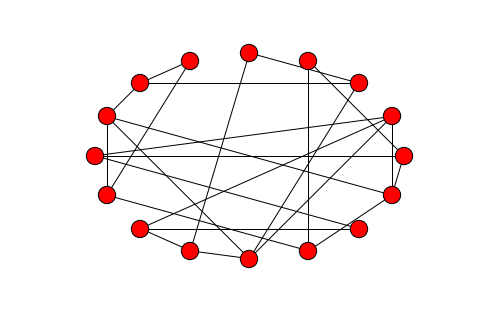

In [109]:
ws_graph_v2 = make_ws_graph_v2(16, 2, 0.5)
nx.draw_circular(ws_graph_v2)

2.6666666666666665

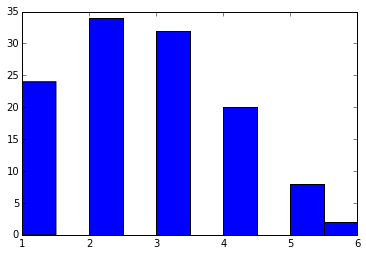

In [111]:
characteristic_path_length(ws_graph_v2, True)

In [114]:
clustering_coefficient(ws_graph_v2)

0.0